## TUIA - Aprendizaje Automático 1 - 2023

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian

El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificacionModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork
from common import split_dataset


2024-02-26 14:19:26.473279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### **Convertimos en variables numéricas las columnas 'RainToday' y 'RainTomorrow'**

In [2]:
df = pd.read_csv(data_source)
df["Date"]=pd.to_datetime(df["Date"])
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# 2) Análisis descriptivo

In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [4]:
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,0.2


In [5]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        145412 non-null  int64         
 1   Date              145412 non-null  datetime64[ns]
 2   Location          145412 non-null  object        
 3   MinTemp           143928 non-null  float64       
 4   MaxTemp           144159 non-null  float64       
 5   Rainfall          142152 non-null  float64       
 6   Evaporation       82658 non-null   float64       
 7   Sunshine          75616 non-null   float64       
 8   WindGustDir       135096 non-null  object        
 9   WindGustSpeed     135159 non-null  float64       
 10  WindDir9am        134850 non-null  object        
 11  WindDir3pm        141186 non-null  object        
 12  WindSpeed9am      143645 non-null  float64       
 13  WindSpeed3pm      142351 non-null  float64       
 14  Humi

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

### **Hay un total de 145412 datos, se puede observar que hay datos nulos.**

## Filtramos por las ciudades de interés

In [6]:
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        15986 non-null  int64         
 1   Date              15986 non-null  datetime64[ns]
 2   Location          15986 non-null  object        
 3   MinTemp           15495 non-null  float64       
 4   MaxTemp           15500 non-null  float64       
 5   Rainfall          15199 non-null  float64       
 6   Evaporation       14280 non-null  float64       
 7   Sunshine          14038 non-null  float64       
 8   WindGustDir       14529 non-null  object        
 9   WindGustSpeed     14531 non-null  float64       
 10  WindDir9am        15291 non-null  object        
 11  WindDir3pm        15696 non-null  object        
 12  WindSpeed9am      15725 non-null  float64       
 13  WindSpeed3pm      15737 non-null  float64       
 14  Humidity9am       

In [7]:
df = df.dropna(subset=['RainTomorrow', 'RainfallTomorrow', 'Humidity3pm', 'Rainfall'])
df['Cloud3pm'] = df.groupby('Location')['Cloud3pm'].transform(lambda x: x.fillna(x.median()))

df.isna().sum()

# los eliminmos porque son el 5% de los dataset

Unnamed: 0             0
Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1675
Sunshine            1926
WindGustDir         1432
WindGustSpeed       1430
WindDir9am           670
WindDir3pm           283
WindSpeed9am         259
WindSpeed3pm         244
Humidity9am           68
Humidity3pm            0
Pressure9am          249
Pressure3pm          232
Cloud9am            1890
Cloud3pm               0
Temp9am               20
Temp3pm                0
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        14993 non-null  int64         
 1   Date              14993 non-null  datetime64[ns]
 2   Location          14993 non-null  object        
 3   MinTemp           14985 non-null  float64       
 4   MaxTemp           14988 non-null  float64       
 5   Rainfall          14993 non-null  float64       
 6   Evaporation       13318 non-null  float64       
 7   Sunshine          13067 non-null  float64       
 8   WindGustDir       13561 non-null  object        
 9   WindGustSpeed     13563 non-null  float64       
 10  WindDir9am        14323 non-null  object        
 11  WindDir3pm        14710 non-null  object        
 12  WindSpeed9am      14734 non-null  float64       
 13  WindSpeed3pm      14749 non-null  float64       
 14  Humidity9am       

### Ahora contamos con un total de 15986 datos.

### Cantidad de valores faltantes:

In [9]:
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp                8
MaxTemp                5
Rainfall               0
Evaporation         1675
Sunshine            1926
WindGustDir         1432
WindGustSpeed       1430
WindDir9am           670
WindDir3pm           283
WindSpeed9am         259
WindSpeed3pm         244
Humidity9am           68
Humidity3pm            0
Pressure9am          249
Pressure3pm          232
Cloud9am            1890
Cloud3pm               0
Temp9am               20
Temp3pm                0
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

### Estadística descriptiva de las variables numéricas

In [10]:
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,14993.000000,14985.000000,14988.000000,14993.000000,13318.000000,13067.000000,13563.000000,14734.000000,14749.000000,14925.000000,14993.000000,14744.000000,14761.000000,13103.000000,14993.000000,14973.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,48360.978857,11.610397,21.796918,2.303728,4.878946,6.906130,44.289464,16.445364,21.731236,68.881407,51.239645,1018.335153,1016.077975,4.738304,4.757954,15.584292,20.273154,0.232709,0.229040,2.252278
std,14822.983185,5.889194,6.053972,7.412942,3.056983,3.837161,14.947313,10.261409,9.530939,15.649304,17.757028,7.404186,7.267747,2.731254,2.415661,5.572528,5.858013,0.422572,0.420229,7.326791
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,33951.000000,7.900000,17.200000,0.000000,2.600000,3.800000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,3.000000,11.600000,16.000000,0.000000,0.000000,0.000000
50%,46774.000000,11.600000,21.300000,0.000000,4.200000,7.600000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,5.000000,15.500000,19.800000,0.000000,0.000000,0.000000
75%,65741.000000,15.900000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.600000,24.200000,0.000000,0.000000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


### Analizamos nuestra variable objetivo, la que queremos predecir para saber si el df esta balanceado o no.

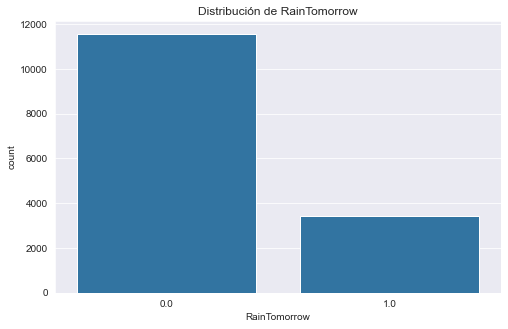

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se puede observar que el dataset no está balanceado

### Histogramas

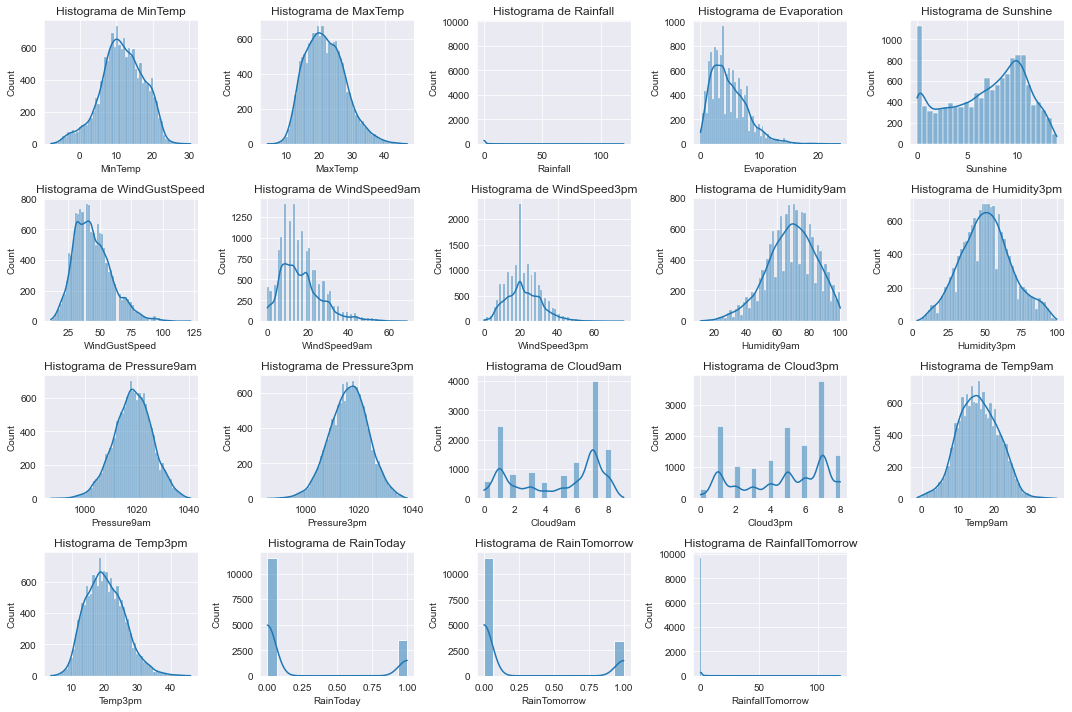

In [12]:
numeric_columns = df.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


# Matriz de correlación 

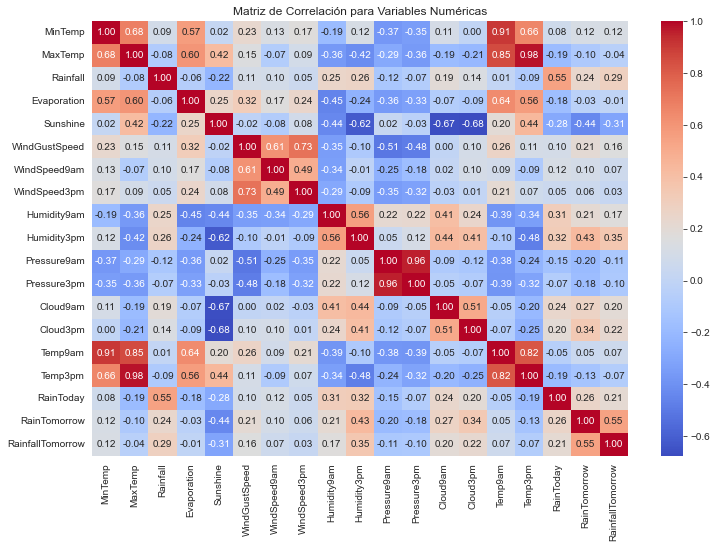

In [13]:
correlation_matrix_numeric = df[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


Podemos observar que las variables con mayor correlación con RainfallTomorrow son:

*   Humidity3pm (0.35)
*   Rainfall (0.29)
*   Cloud3pm (0.25)
*   Sunshine (-0.31)

y las variables con mayor correlación con RainTomorrow son:

*   Humidity3pm (0,42)
*   Cloud3pm (0.37)
*   Rainfall (0,24)
*   Sunshine (-0,43)

## Realizamos el split de entrenamiento y prueba

In [14]:
location_mapping = {'Canberra': 0, 'Melbourne': 1, 'MelbourneAirport': 2, 'Sydney': 3, 'SydneyAirport': 4}
df['Location___']=df['Location'].map(location_mapping)
df['Location']=df['Location___']
_x_train, _x_test, _y_train_regression, _y_test_regression, _y_train_classification, y_test_classification = split_dataset(df)

## Realizamos la limpieza en la clase clean y volvemos a visualizar los datos

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [15]:
regresion_clasic = RegressionLineal()
x_test, y_test_regression, y_pred, modelo = regresion_clasic.classic(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal clasic:")
regresion_clasic.metrics(y_test_regression, y_pred)

Métricas del modelo Regresion lineal clasic:
MSE: 44.64635910356854
R^2: 0.24142810860735353
RMSE: 6.681793105414784
MAE: RainfallTomorrow    3.154499
dtype: float64
MAPE: RainfallTomorrow    inf
dtype: float64


In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


In [16]:
#aplicamos validación cruzada
regresion_clasic.cross_validate(_y_test_regression, _y_test_regression, modelo, cv=5)

Mean Squared Error (CV): 7.501424879226929e-28
R^2 Score (CV): 1.0
Mean Absolute Error (CV): 1.1210883283173034e-14


(7.501424879226929e-28, 1.0, 1.1210883283173034e-14)

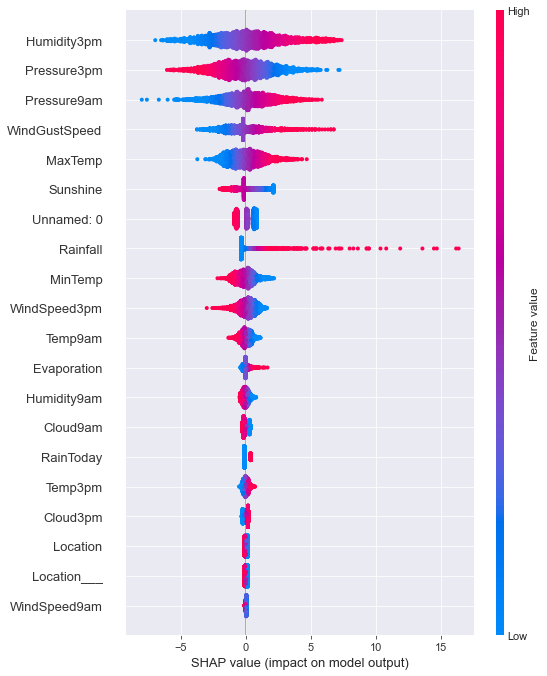

In [17]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [18]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal()
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del Modelo:")
regresion_gradient_desecent.metrics(y_test, y_pred)


métodos de gradiente descendiente
Métricas del Modelo:
MSE: 48.464279388674946
R^2: 0.17655905612445955
RMSE: 6.961629075774933
MAE: 3.3753102917470628
MAPE: nan


In [19]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 75.21477502561719
R^2 Score (CV): -0.27794998959488293
Mean Absolute Error (CV): 5.498844831310766


(75.21477502561719, -0.27794998959488293, 5.498844831310766)

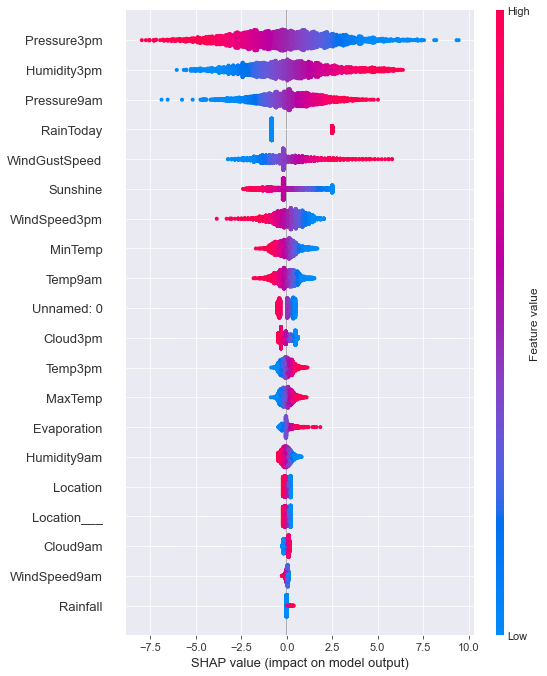

In [20]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [21]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}


regresion_gradient_descent = RegressionLineal()
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid,
                                                                                                          _x_train, _x_test, _y_train_regression, _y_test_regression)

regresion_gradient_descent.metrics(y_test, y_pred)

MSE: 53.633270998446704
R^2: 0.0887343864146315
RMSE: 7.323473970626694
MAE: 3.263552277984982
MAPE: nan


## Regresión linean de Lasso

In [22]:
# regresion de Lasso
regresion_lasso = RegressionLineal()
x_test, y_test, y_pred, lasso_model = regresion_lasso.lasso_regression(_x_train, _x_test, _y_train_regression, _y_test_regression)
print(f"Métricas del modelo Regresion lineal Lasso:")
regresion_lasso.metrics(y_test, y_pred)

Métricas del modelo Regresion lineal Lasso:


ValueError: Unable to coerce to Series, length must be 1: given 2999

In [ ]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(lasso_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Lasso', param_grid_lasso)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


## Regresión lineal de Ridge

In [ ]:
# regresion de Ridge

regresion_ridge = RegressionLineal(data_clean)
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Ridge:")
print(metricas)


In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Ridge', param_grid_Ridge)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Ridge:")
print(metricas_lasso)
print("Mejores hiperparámetros para Ridge:", best_lasso_model.get_params())

## Regresión lineal de Elasticnet

In [ ]:
# regresion de Elasticnet

regresion_elasticnet = RegressionLineal(data_clean)
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression()

metricas = regresion_elasticnet.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
print(metricas)

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters('ElasticNet', param_grid_Elasticnet)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

## Regresión Logística

In [ ]:
#regresion logistica
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic()
regression_logistic.logic_metrics(y_test, y_pred)

In [ ]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [ ]:
regresion_lineal = RegressionLineal(data_clean)
#buscando los hipperparametros
param_grid_logistic = {
    'C': [ 0.01, 0.1],
    'penalty': ['l1'],
    'solver': ['liblinear']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(param_grid_logistic)

# Calcular métricas
metricas_logistic = regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print(f"Métricas del mejor modelo de regresión logística:")
print(metricas_logistic)
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


### Observamos que tanto el modelo como la validación cruzada tienden a sobreajustar las predicciones hacia la clase negativa. Esto se debe a que la clase negativa es la más predominante. Para abordar este desbalance, procedemos a equilibrar las clases.

In [ ]:
#regresion logistica balanceada
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic_balanced()
regression_logistic.logic_metrics(y_test, y_pred)

### Optamos por mantener el modelo balanceado, ya que aunque observamos una disminución en las métricas de predicción negativa, consideramos prioritario mejorar las métricas de predicción positiva. En este contexto, valoramos una mayor precisión en la anticipación de días lluviosos.

## Implementar un modelo base para clasificación y uno para regresión

In [ ]:

# Ejemplo de uso
# Supongamos que tienes un DataFrame llamado 'data_clean' con las características relevantes y la etiqueta 'RainTomorrow'
clasificacion_modelo_base = ClasificacionModelBase(data_clean)
metricas_rendimiento_base = clasificacion_modelo_base.train_and_evaluate()

# Mostrar métricas de rendimiento
print("Métricas de rendimiento del modelo base de clasificación:")
for metric, value in metricas_rendimiento_base.items():
    print(f"{metric}: {value:.2f}")

In [ ]:

# Ejemplo de uso
# Suponiendo que tienes un DataFrame llamado 'data' con las columnas 'Temp3pm' y 'RainfallTomorrow'
modelo_regresion_base = RegresionModelBase(data_clean)
modelo_entrenado, error_cuadratico_medio, coeficiente_determinacion = modelo_regresion_base.train()

# Mostrar métricas de rendimiento
print("Métricas de rendimiento:")
print(f"Error cuadrático medio (MSE): {error_cuadratico_medio:.2f}")
print(f"Coeficiente de determinación (R^2): {coeficiente_determinacion:.2f}")


## Implementar las soluciones con una red neuronal

In [ ]:
print('=============================clasificacion con redes neuronales================================================')
classification_nn_model = ClassificationNeuralNetwork(data_clean)
trained_model = classification_nn_model.classification()


In [ ]:
regression_nn_model = RegressionNeuralNetwork(data_clean)
regression_nn_model.regression()